In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=3a98a2c6d71a7517283c13d7f84ec6ac652a970501e9d479e6a6fab2a8a7aa75
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import wandb
from ast import literal_eval

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z" -O data.zip && rm -rf /tmp/cookies.txt
!unzip data.zip -d data

--2023-08-10 13:59:06--  https://docs.google.com/uc?export=download&confirm=t&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z
Resolving docs.google.com (docs.google.com)... 173.194.212.102, 173.194.212.113, 173.194.212.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.212.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9vpe08vilketlt8l2n17ek9a5o73pnme/1691675925000/12559052158801778725/*/16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z?e=download&uuid=087486dc-6eaa-4a06-ba84-c5b77518a8dc [following]
--2023-08-10 13:59:07--  https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9vpe08vilketlt8l2n17ek9a5o73pnme/1691675925000/12559052158801778725/*/16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z?e=download&uuid=087486dc-6eaa-4a06-ba84-c5b77518a8dc
Resolving doc-0c-6c-docs.googleusercontent.com (doc-0c-6c-docs.googleusercontent.com)... 173.194.211.

In [4]:
config = {
    #science, reference and difference image each 63 X 63 pixels
    'image_size': (63,63,3),
    'metadata_size': (14,),
    'dropout_1': 0.3,
    'dropout_2': 0.3,
    'dropout_3': 0.3,
}

In [5]:
def BTSModel(config):
    #image size and metadata size might be strings, so we convert them to tuples with a literal eval
    if type(config["image_size"]) == str:
        image_size = literal_eval(config["image_size"])
    else:
        image_size = config["image_size"]
    if type(config["metadata_size"]) == str:
        metadata_size = literal_eval(config["metadata_size"])
    else:
        metadata_size = config["metadata_size"]

    # Initialise inputs with desired shapes
    triplet_input = keras.Input(shape=image_size, name='triplet')
    meta_input = keras.Input(shape=metadata_size, name='metadata')

    # FIRST CONV BLOCK
    x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(63, 63, 3), name='conv1')(triplet_input)
    x_conv = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x_conv)
    x_conv = MaxPooling2D(pool_size=(2, 2), name='pool1')(x_conv)
    x_conv = Dropout(config["dropout_1"], name='drop1')(x_conv)

    # SECOND CONV BLOCK
    x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x_conv)
    x_conv = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4')(x_conv)
    x_conv = MaxPooling2D(pool_size=(4, 4), name='pool2')(x_conv)
    x_conv = Dropout(config["dropout_2"], name='drop2')(x_conv)

    #Flatten the layer for convenient o/p
    x_conv = Flatten()(x_conv)

    # REGULAR NEURAL NETWORK FOR METADATA
    x_meta = Dense(16, activation='relu', name='metadata_fc_1')(meta_input)
    x_meta = Dense(32, activation='relu', name='metadata_fc_2')(x_meta)

    x = Concatenate(axis=1)([x_conv, x_meta])
    x = Dense(16, activation='relu', name='comb_fc_2')(x)
    x = Dropout(config["dropout_3"])(x)

    output = Dense(1, activation='sigmoid', name='fc_out')(x)

    model = keras.Model(inputs=[triplet_input, meta_input], outputs=output, name="mi_cnn")

    return model

In [6]:
config.update({
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.001,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 10,
    'LR_plateau_patience': 20,
    'reduce_LR_factor': 0.5,
    'reduce_LR_minLR': 1e-6,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'metadata_cols': [
      "sgscore1",
      "distpsnr1",
      "sgscore2",
      "distpsnr2",
      "fwhm",
      "magpsf",
      "sigmapsf",
      "ra",
      "dec",
      "diffmaglim",
      "ndethist",
      "nmtchps",
      "age",
      "peakmag_so_far"
    ],
})

In [7]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(config["random_seed"])

In [8]:
# LOAD THE DATA
cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
triplets = np.load(f'data/train_triplets_{config["train_data_version"]}.npy', mmap_mode='r')
val_cand = pd.read_csv(f'data/val_cand_{config["train_data_version"]}.csv')
val_triplets = np.load(f'data/val_triplets_{config["train_data_version"]}.npy', mmap_mode='r')

gen_cols = np.append(config['metadata_cols'], ['label'])

# TRAINING AND VALIDATION DATA
x_train, y_train = triplets, cand['label']
x_val, y_val = val_triplets, val_cand['label']

train_df = cand[gen_cols]
val_df = val_cand[gen_cols]

In [9]:
# DATA AUGMENTATION

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

def multiinput_train_generator():
    while True:
        data = t_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

def multiinput_val_generator():
    while True:
        data = v_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

training_generator = multiinput_train_generator()
validation_generator = multiinput_val_generator()

# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(cand['label'] == 0), np.sum(cand['label'] == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights)

class_weight = {i: w for i, w in enumerate(normalized_weight)}

In [10]:
# Early stopping if learning stagnates
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=config['early_stopping_patience']
)

#Lower learning rate on encountering plateau
LR_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=config['LR_plateau_patience'],
    factor=config['reduce_LR_factor'],
    min_lr=config['reduce_LR_minLR'],
    verbose=0
)

In [11]:
wandb.init(project="BTSbot")

for param in list(config):
    wandb.config[param] = config[param]

run_name = wandb.run.name
WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
model=BTSModel(config)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=config['learning_rate'],
    beta_1=config['beta_1'],
    beta_2=config['beta_2']
)
model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])

In [13]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=config["epochs"],
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/10
258/258 [==============================] - 171s 657ms/step - loss: 0.7705 - accuracy: 0.6447 - val_loss: 0.7099 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 2/10
258/258 [==============================] - 171s 663ms/step - loss: 0.6430 - accuracy: 0.6628 - val_loss: 0.6782 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 3/10
258/258 [==============================] - 148s 576ms/step - loss: 0.6185 - accuracy: 0.6879 - val_loss: 0.6365 - val_accuracy: 0.6596 - lr: 0.0010
Epoch 4/10
258/258 [==============================] - 143s 555ms/step - loss: 0.5604 - accuracy: 0.7341 - val_loss: 0.6190 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 5/10
258/258 [==============================] - 170s 660ms/step - loss: 0.5388 - accuracy: 0.7521 - val_loss: 0.6054 - val_accuracy: 0.6919 - lr: 0.0010
Epoch 6/10
258/258 [==============================] - 168s 654ms/step - loss: 0.5300 - accuracy: 0.7532 - val_loss: 0.6600 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 7/10
258/258 [==========================

In [14]:
raw_preds = model.predict([triplets, cand.loc[:,config["metadata_cols"]]], batch_size=config['batch_size'], verbose=1)
raw_preds

324/324 [==============================] - 27s 84ms/step


array([[0.33522192],
       [0.39033067],
       [0.14788833],
       ...,
       [0.86777884],
       [0.28539777],
       [0.91217464]], dtype=float32)

In [15]:
preds = np.rint(np.transpose(raw_preds))[0].astype(int)
labels = cand["label"].to_numpy(dtype=int)

results = preds == labels
print(f"Overall validation accuracy {100*np.sum(results) / len(results):.2f}%")

Overall validation accuracy 78.43%


In [16]:
!pip install scikit-learn

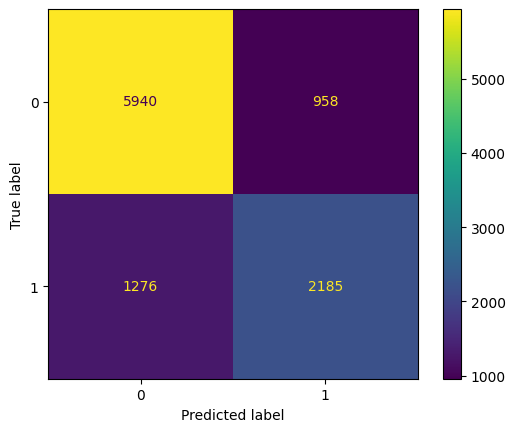

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score

print('Precision Score=',precision_score(labels,preds))
print('Recall Score=',recall_score(labels,preds))
print('F1 Score=',f1_score(labels,preds))

Precision Score= 0.695195672923958
Recall Score= 0.6313204276220745
F1 Score= 0.6617201695941852
